In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('matplotlib.mathtext').setLevel(logging.WARNING)

import sys, os
sys.path.append(os.path.abspath("metrics"))

from models.sbts_uni_markovian import *
from models.sbts_multi_markovian import *
from metrics.eval_functions import *
from metrics.get_params import *
from utils.data_generation import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Parameters Estimation: Illustration on Ornstein-Uhlenbeck Data

In [52]:
M = 500
Generate_OU = Generate_Data(M)

theta_range = [0.5, 2.5]
mu_range = [0.5, 1.5]
sigma_range = [0.1, 0.5]
N = 252
deltati = 1/252
x0=1

X_ou = Generate_OU.generate_OU(theta_range, mu_range, sigma_range, N, deltati, x0)
X_ou_return = np.zeros((M, N+1))
X_ou_return[:,1:] = np.diff(np.log(X_ou), axis=1)

X_ou_return_sbts = simusbts_mark(N, M, K=1, X=X_ou_return, N_pi=100, h=0.4, deltati=deltati, M_simu=500)
X_ou_sbts = np.exp(X_ou_return_sbts.cumsum(axis=1))
X_ou = X_ou[:, 1:]

Start time: 07:00:45
Expected finish time: 07:03:04
Finish time: 07:02:33
Time with numba to generate 500 samples with N_pi=100: 108 seconds.


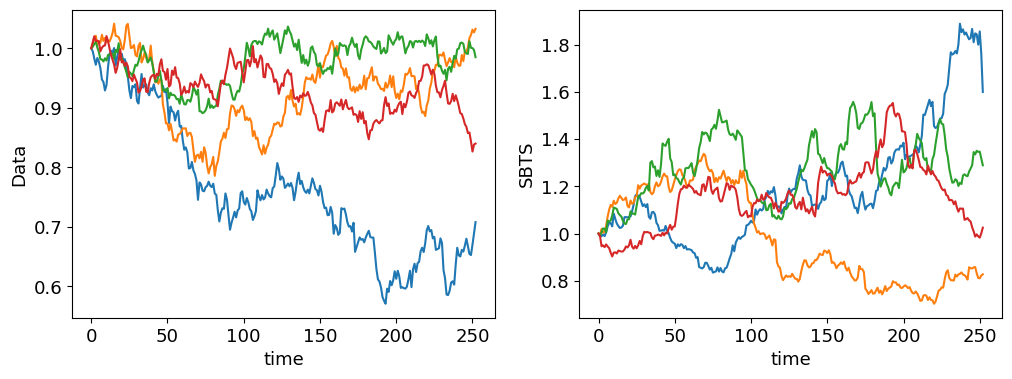

In [53]:
plot_sample(X_ou, X_ou_sbts, 1)

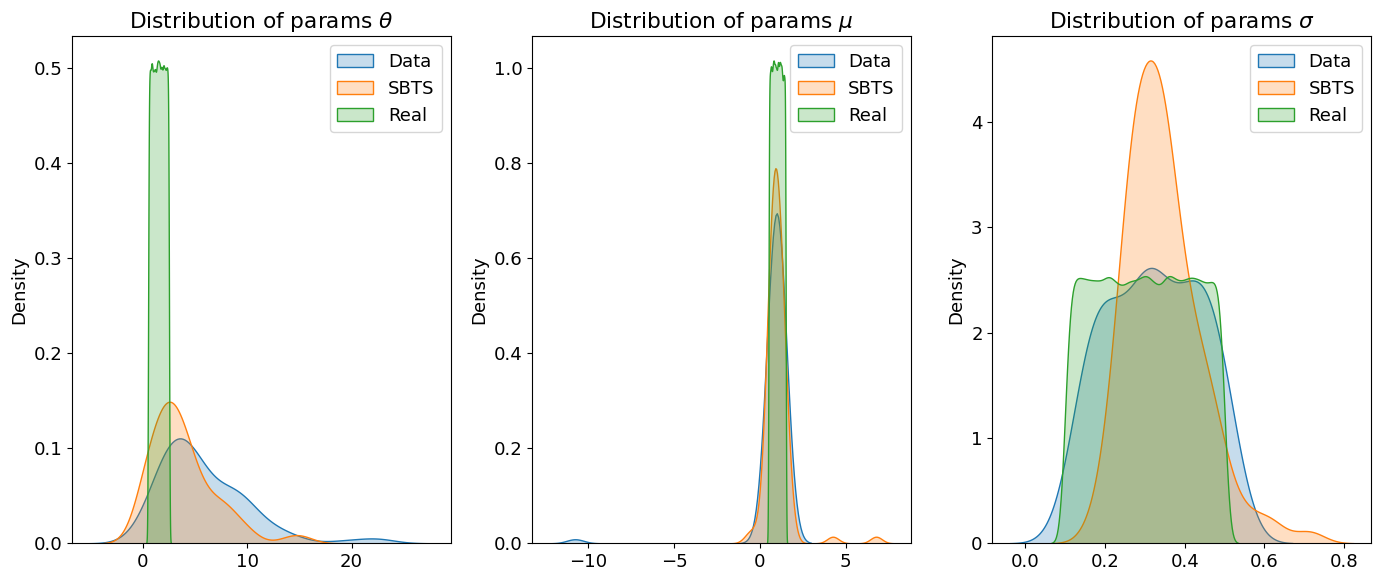

In [42]:
plot_params_distrib_OU(X_ou, X_ou_sbts, dt=deltati)

## Discriminative and Predictive Score Computation: Illustration on Multivariate AR Data

In [4]:
M = 1000
Generate_AR_multi = Generate_Data(M)

N = 24
d=5
phi=0.5
sigma=0.8
x0=0
deltati = 1

X_ar = Generate_AR_multi.generate_AR_multi(N, d, phi, sigma, x0)

X_ar_sbts = simulateSB_multi_mark(N, M, d, K=1, X=X_ar, N_pi=100, h=0.5, deltati=deltati, M_simu=1000)
X_ar = X_ar[:, 1:]

Start time: 10:18:34
Expected finish time: 10:20:51
Finish time: 10:21:14
Time with numba to generate 1000 samples with N_pi=100: 159 seconds.


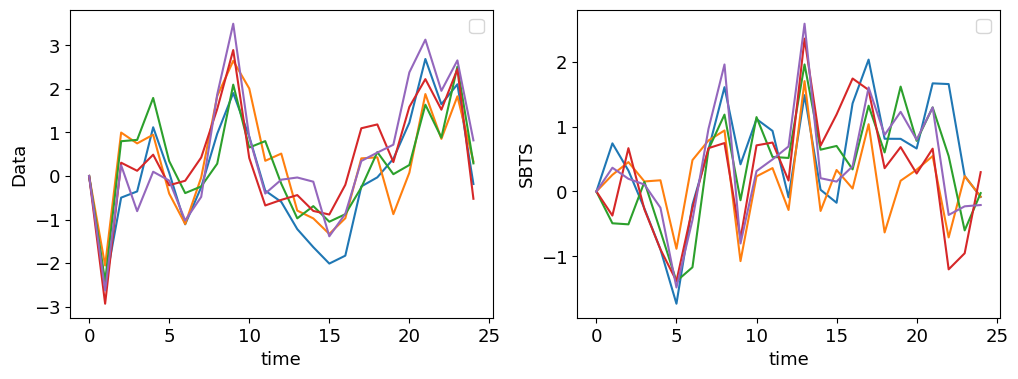

In [34]:
plot_sample_multi(X_ar, X_ar_sbts, x0=0)

In [6]:
get_stats(X_ar, X_ar_sbts)

,1% Data,1% SBTS,99% Data,99% SBTS,Mean Data,Mean SBTS,Std Data,Std SBTS,Min Data,Min SBTS,Max Data,Max SBTS
Feature,,,,,,,,,,,,
0,-2.659,-2.650,2.712,2.785,0.046,0.061,1.156,1.165,-5.041,-4.476,4.584,4.605
1,-2.649,-2.703,2.714,2.744,0.030,0.041,1.159,1.183,-5.202,-8.339,4.795,7.027
2,-2.681,-2.731,2.711,2.772,0.031,0.047,1.159,1.180,-4.899,-5.933,4.480,5.682
3,-2.676,-2.727,2.677,2.724,0.031,0.040,1.152,1.168,-4.817,-5.762,4.216,8.234
4,-2.654,-2.617,2.730,2.774,0.045,0.059,1.150,1.160,-4.768,-4.353,4.714,5.055


In [5]:
disc, pred = get_scores(X_ar, X_ar_sbts, itt=2000, n_temp=10, min_max=True, device=device)

Start time: 10:21:14
Expected finish time: 11:02:21
Discriminative score (lower the better): 0.035 +- 0.022
Predictive score (lower the better): 0.09 +- 0.002
